In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import tqdm

import celltrip


# Load Data and Policy

In [3]:
# Load train and validation data
adatas_train = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_expression.h5ad',
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_spatial.h5ad',
    backed=True)
adata_val, = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_sc_expression.h5ad',
    backed=True)
# Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250919', 800  # On lognorm data from authors
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250922', 800  # Raw data - best so far
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251013', 800  # Raw data - 32 dim
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Create sample env (kind of a dumb workaround, TODO)
m1, m2 = [preprocessing.transform(ad[:2].X, subset_modality=i)[0] for i, ad in enumerate(adatas_train)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # , pinning_spatial=[1]
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
# Load expression data
train_exp = adatas_train[0].X[:]
val_exp = adata_val.X[:]

# Scale with mean and std
train_exp_log = np.log1p(train_exp)
val_exp_log = np.log1p(val_exp)
val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0)) / val_exp_log.std(keepdims=True, axis=0)
val_exp_log_corrected = val_exp_log_norm * train_exp_log.std(keepdims=True, axis=0) + train_exp_log.mean(keepdims=True, axis=0)
val_exp_log_corrected = np.nan_to_num(val_exp_log_corrected)
val_exp_corrected = np.expm1(val_exp_log_corrected)
val_exp_corrected = val_exp_corrected * 10_000 / val_exp_corrected.sum(keepdims=True, axis=1)

# Scale with mean
# train_exp_log = np.log1p(train_exp)
# val_exp_log = np.log1p(val_exp)
# val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0))
# val_exp_log_corrected = val_exp_log_norm + train_exp_log.mean(keepdims=True, axis=0)
# val_exp_log_corrected = np.nan_to_num(val_exp_log_corrected)
# val_exp_corrected = np.expm1(val_exp_log_corrected)
# val_exp_corrected[val_exp_corrected < 0] = 0
# val_exp_corrected = val_exp_corrected * 10_000 / val_exp_corrected.sum(keepdims=True, axis=1)

# Visualize differences
# import umap
# red = umap.UMAP()  # random_state=42
# train_red = red.fit_transform(train_exp)
# val_red = red.transform(val_exp)
# val_corr_red = red.transform(val_exp_corrected)
# plt.scatter(*train_red.T)
# plt.scatter(*val_red.T)
# plt.scatter(*val_corr_red.T)

/tmp/ipykernel_33105/3593917406.py:8: RuntimeWarning: invalid value encountered in divide
  val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0)) / val_exp_log.std(keepdims=True, axis=0)


# Generate Steady State

In [5]:
# Initialize validation environment
# m1, = preprocessing.transform(val_exp, subset_modality=0)
m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1, :, :env.dim]
# target_state = env.modalities[env.target_modalities[0]].cpu()
with torch.no_grad():
    imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()  # , Y=target_state.to('cuda')
imputed_steady_state, = preprocessing.inverse_transform(imputed_steady_state, subset_modality=1)

# Use OT to match distributions
a, b, M_raw, OT_mat = celltrip.utility.general.compute_discrete_ot_matrix(imputed_steady_state, adatas_train[1].X[:])
max_idx = OT_mat.argmax(axis=1)
imputed_steady_state_OT = adatas_train[1].X[:][max_idx]
cost = M_raw[np.arange(M_raw.shape[0]), max_idx]

# Match distribution means
diff = adatas_train[1].X[:].mean(axis=0) - imputed_steady_state.mean(axis=0)

# Warp data to match distribution
train_spat = adatas_train[1].X[:]
imputed_steady_state_warp = (imputed_steady_state - imputed_steady_state.mean(keepdims=True, axis=0)) / imputed_steady_state.std(keepdims=True, axis=0)
imputed_steady_state_warp = (imputed_steady_state_warp * train_spat.std(keepdims=True, axis=0) + train_spat.mean(keepdims=True, axis=0))

# Filters
manual_mask = (imputed_steady_state[:, 1]<7000) * (imputed_steady_state[:, 1]>5000)  # Manual
cost_mask = cost < np.quantile(cost, .5)  # Cost
close_mask = scipy.spatial.distance_matrix(imputed_steady_state, adatas_train[1].X[:]).min(axis=1) < 100  # Distance from training

# Save
np.save(f'../plots/cortex/CellTRIP_Validation.npy', imputed_steady_state)
np.save(f'../plots/cortex/CellTRIP_Diff_Validation.npy', imputed_steady_state+diff)
np.save(f'../plots/cortex/CellTRIP-OT_Validation.npy', imputed_steady_state_OT)
np.save(f'../plots/cortex/CellTRIP-Warp_Validation.npy', imputed_steady_state_warp)
# Filters
np.save(f'../plots/cortex/CellTRIP-Manual_Mask.npy', cost_mask)
np.save(f'../plots/cortex/CellTRIP-Cost_Mask.npy', cost_mask)
np.save(f'../plots/cortex/CellTRIP-Close_Mask.npy', close_mask)



0it [00:00, ?it/s]


1it [00:00,  1.29it/s]


9it [00:00, 13.33it/s]


17it [00:00, 24.86it/s]


25it [00:01, 35.30it/s]


33it [00:01, 44.24it/s]


41it [00:01, 51.51it/s]


49it [00:01, 57.14it/s]


57it [00:01, 61.27it/s]


65it [00:01, 64.57it/s]


73it [00:01, 67.01it/s]


81it [00:01, 68.75it/s]


89it [00:01, 70.07it/s]


97it [00:02, 71.03it/s]


105it [00:02, 71.54it/s]


113it [00:02, 72.05it/s]


121it [00:02, 72.40it/s]


129it [00:02, 72.71it/s]


137it [00:02, 72.84it/s]


145it [00:02, 72.99it/s]


153it [00:02, 73.12it/s]


161it [00:02, 73.04it/s]


169it [00:03, 72.76it/s]


177it [00:03, 72.57it/s]


185it [00:03, 72.80it/s]


193it [00:03, 72.93it/s]


201it [00:03, 72.90it/s]


209it [00:03, 73.00it/s]


217it [00:03, 73.13it/s]


225it [00:03, 72.46it/s]


233it [00:03, 72.74it/s]


241it [00:04, 72.85it/s]


249it [00:04, 72.96it/s]


257it [00:04, 73.08it/s]


265it [00:04, 69.02it/s]


272it [00:04, 65.50it/s]


279it [00:04, 62.78it/s]


286it [00:04, 63.80it/s]


294it [00:04, 66.57it/s]


302it [00:04, 68.43it/s]


310it [00:05, 69.93it/s]


318it [00:05, 71.00it/s]


326it [00:05, 71.76it/s]


334it [00:05, 72.24it/s]


342it [00:05, 72.61it/s]


350it [00:05, 72.86it/s]


358it [00:05, 73.11it/s]


366it [00:05, 73.23it/s]


374it [00:05, 73.33it/s]


382it [00:06, 73.40it/s]


390it [00:06, 73.38it/s]


398it [00:06, 73.42it/s]


406it [00:06, 73.23it/s]


414it [00:06, 73.31it/s]


422it [00:06, 73.31it/s]


430it [00:06, 73.35it/s]


438it [00:06, 73.39it/s]


446it [00:06, 73.44it/s]


454it [00:07, 73.50it/s]


462it [00:07, 73.49it/s]


470it [00:07, 73.51it/s]


478it [00:07, 73.52it/s]


486it [00:07, 73.54it/s]


494it [00:07, 73.54it/s]


502it [00:07, 73.24it/s]


510it [00:07, 73.29it/s]


518it [00:07, 73.30it/s]


526it [00:08, 73.28it/s]


534it [00:08, 72.98it/s]


542it [00:08, 73.11it/s]


550it [00:08, 73.20it/s]


558it [00:08, 73.23it/s]


566it [00:08, 73.19it/s]


574it [00:08, 73.16it/s]


582it [00:08, 73.22it/s]


590it [00:08, 73.28it/s]


598it [00:09, 73.26it/s]


606it [00:09, 72.39it/s]


614it [00:09, 72.63it/s]


622it [00:09, 72.80it/s]


630it [00:09, 72.98it/s]


638it [00:09, 73.03it/s]


646it [00:09, 73.06it/s]


654it [00:09, 73.07it/s]


662it [00:09, 73.07it/s]


670it [00:10, 69.48it/s]


677it [00:10, 65.37it/s]


684it [00:10, 63.16it/s]


691it [00:10, 61.15it/s]


698it [00:10, 56.59it/s]


704it [00:10, 55.30it/s]


710it [00:10, 55.98it/s]


716it [00:10, 55.31it/s]


722it [00:11, 48.79it/s]


728it [00:11, 44.92it/s]


733it [00:11, 42.75it/s]


738it [00:11, 41.19it/s]


743it [00:11, 40.17it/s]


748it [00:11, 39.48it/s]


752it [00:11, 39.11it/s]


756it [00:11, 38.70it/s]


760it [00:12, 38.56it/s]


764it [00:12, 38.28it/s]


768it [00:12, 37.83it/s]


772it [00:12, 37.73it/s]


776it [00:12, 38.07it/s]


780it [00:12, 37.95it/s]


784it [00:12, 37.94it/s]


788it [00:12, 37.65it/s]


792it [00:12, 37.29it/s]


796it [00:12, 37.31it/s]


800it [00:13, 37.11it/s]


804it [00:13, 37.52it/s]


808it [00:13, 37.44it/s]


812it [00:13, 37.50it/s]


816it [00:13, 37.44it/s]


820it [00:13, 37.26it/s]


824it [00:13, 37.26it/s]


828it [00:13, 37.15it/s]


832it [00:13, 36.89it/s]


836it [00:14, 37.14it/s]


840it [00:14, 37.36it/s]


844it [00:14, 36.89it/s]


848it [00:14, 37.57it/s]


852it [00:14, 38.20it/s]


857it [00:14, 38.81it/s]


862it [00:14, 39.29it/s]


867it [00:14, 39.56it/s]


872it [00:14, 39.74it/s]


876it [00:15, 39.74it/s]


880it [00:15, 39.81it/s]


885it [00:15, 40.02it/s]


890it [00:15, 40.01it/s]


895it [00:15, 40.10it/s]


900it [00:15, 39.92it/s]


905it [00:15, 40.04it/s]


910it [00:15, 40.18it/s]


915it [00:16, 40.17it/s]


920it [00:16, 40.17it/s]


925it [00:16, 40.25it/s]


930it [00:16, 40.17it/s]


935it [00:16, 40.16it/s]


940it [00:16, 40.12it/s]


945it [00:16, 40.22it/s]


950it [00:16, 40.07it/s]


955it [00:17, 40.06it/s]


960it [00:17, 40.26it/s]


965it [00:17, 40.17it/s]


970it [00:17, 40.18it/s]


975it [00:17, 40.15it/s]


980it [00:17, 40.24it/s]


985it [00:17, 40.22it/s]


990it [00:17, 40.23it/s]


995it [00:18, 40.23it/s]


1000it [00:18, 40.02it/s]


1005it [00:18, 39.95it/s]


1009it [00:18, 39.93it/s]


1014it [00:18, 40.02it/s]


1019it [00:18, 40.13it/s]


1024it [00:18, 40.20it/s]


1029it [00:18, 40.14it/s]


1034it [00:19, 40.24it/s]


1039it [00:19, 40.17it/s]


1044it [00:19, 40.26it/s]


1049it [00:19, 40.33it/s]


1054it [00:19, 40.33it/s]


1059it [00:19, 40.25it/s]


1064it [00:19, 40.29it/s]


1069it [00:19, 40.19it/s]


1074it [00:20, 40.23it/s]


1079it [00:20, 40.26it/s]


1084it [00:20, 40.24it/s]


1089it [00:20, 40.21it/s]


1094it [00:20, 40.22it/s]


1099it [00:20, 40.25it/s]


1104it [00:20, 40.14it/s]


1109it [00:20, 40.17it/s]


1114it [00:21, 40.21it/s]


1119it [00:21, 40.06it/s]


1124it [00:21, 40.20it/s]


1129it [00:21, 40.41it/s]


1134it [00:21, 40.45it/s]


1139it [00:21, 40.19it/s]


1144it [00:21, 40.17it/s]


1149it [00:21, 40.23it/s]


1154it [00:22, 40.19it/s]


1159it [00:22, 40.26it/s]


1164it [00:22, 40.27it/s]


1169it [00:22, 40.29it/s]


1174it [00:22, 40.32it/s]


1179it [00:22, 40.45it/s]


1184it [00:22, 40.37it/s]


1189it [00:22, 40.42it/s]


1194it [00:22, 40.39it/s]


1199it [00:23, 40.36it/s]


1204it [00:23, 40.20it/s]


1209it [00:23, 40.37it/s]


1214it [00:23, 40.32it/s]


1219it [00:23, 40.38it/s]


1224it [00:23, 40.38it/s]


1229it [00:23, 40.39it/s]


1234it [00:23, 40.34it/s]


1239it [00:24, 40.34it/s]


1244it [00:24, 40.27it/s]


1249it [00:24, 40.27it/s]


1254it [00:24, 40.24it/s]


1259it [00:24, 39.96it/s]


1264it [00:24, 40.02it/s]


1269it [00:24, 39.93it/s]


1273it [00:24, 39.81it/s]


1277it [00:25, 39.78it/s]


1281it [00:25, 39.57it/s]


1281it [00:25, 50.86it/s]

## Preview

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sklearn.neighbors

In [7]:
# Load additional methods
cytospace_df = pd.read_csv(f'../plots/cortex/Cytospace_Validation.csv')
cytospace_mask = np.isin(adata_val.obs.index, cytospace_df['OriginalCID'])
celltrek_df = pd.read_csv(f'../plots/cortex/CellTREK_Validation.csv', index_col=0)
celltrek_mask = np.isin(adata_val.obs.index, celltrek_df.index)
ground_truth_df = pd.read_csv(f'../plots/cortex/Groundtruth_Validation.csv')

# Params
cluster_order = np.array([5, 2, 7, 1, 4, 6])
layer_order = np.array(['L1', 'L2/3', 'L4', 'L5', 'L6', 'L6b'])
subclass_order = np.array(['Astro', 'Vip', 'Lamp5', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'NP', 'Pvalb', 'Sst', 'L6 IT', 'L6b'])

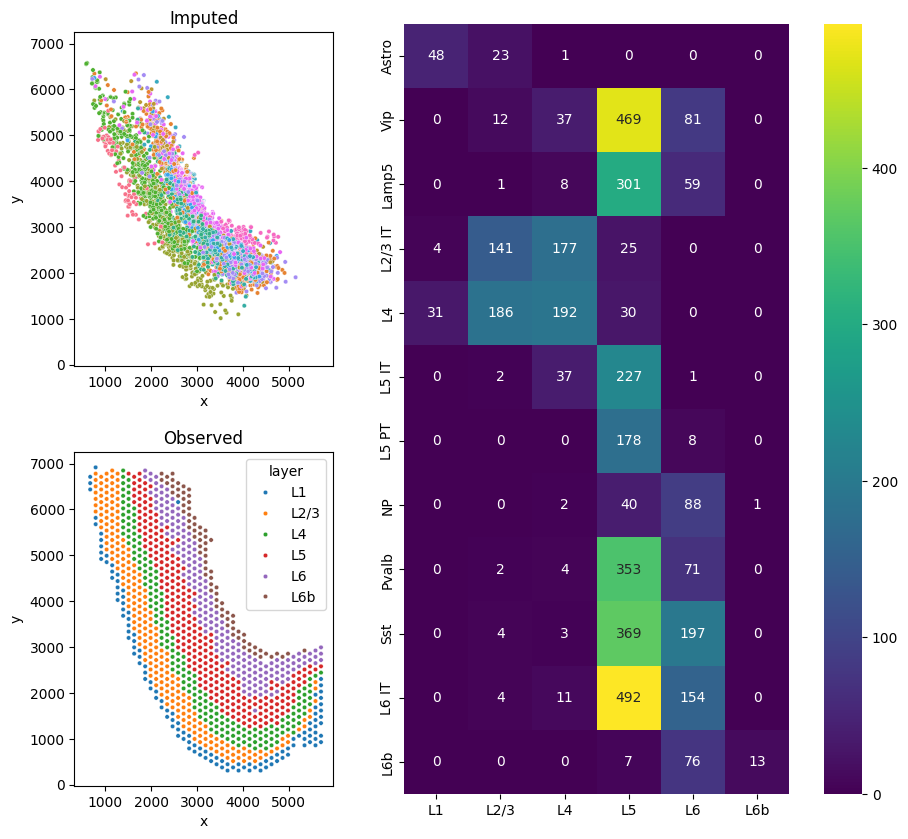

In [8]:
# Format true data
df_true = pd.DataFrame(index=adatas_train[1].obs.index)
df_true[['x', 'y']] = adatas_train[1].X[:]
df_true['cluster'] = adatas_train[1].obs['seurat_clusters']
df_true['layer'] = df_true['cluster'].replace({k: v for k, v in zip(cluster_order, layer_order)})

# Get imputed df
df_impute = pd.DataFrame(index=adata_val.obs.index)
imputed_to_use = imputed_steady_state
# imputed_to_use = imputed_steady_state + diff
# imputed_to_use = imputed_steady_state_OT
# imputed_to_use = imputed_steady_state_warp
df_impute[['x', 'y']] = imputed_to_use
df_impute['subclass'] = adata_val.obs['subclass']
# Layers
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'])
layers = knn.predict(imputed_to_use)
df_impute['layer'] = layers
# Filter
mask = close_mask
# mask = cytospace_mask
# mask = celltrek_mask
df_impute = df_impute.loc[mask]
# Construct heatmap
pivot_df = (
    df_impute.groupby(['subclass', 'layer'], observed=False).size()
    .reset_index(name='Count')
    .pivot(index='subclass', columns='layer', values='Count'))
pivot_df = pivot_df.fillna(0)
# pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)  # Row normalize
try:
    pivot_df = pivot_df.loc[subclass_order, cluster_order]
    pivot_df.columns = layer_order
except: pass

# Scatter
fig = plt.figure(figsize=(11, 10))
gs = mpl.gridspec.GridSpec(2, 2, fig, width_ratios=[3, 8], wspace=-.2)
ax_impute = fig.add_subplot(gs[0, 0])
ax_true = fig.add_subplot(gs[1, 0], sharex=ax_impute, sharey=ax_impute)
ax_heat = fig.add_subplot(gs[:, 1])

# Imputed and true
sns.scatterplot(df_impute, x='x', y='y', hue='subclass', hue_order=subclass_order, s=10., legend=False, ax=ax_impute)
ax_impute.set_title('Imputed')
ax_impute.set_aspect('equal')
# axs[0].set(xlim=[500, 6_000], ylim=[0, 7_000])
sns.scatterplot(df_true, x='x', y='y', hue='layer', hue_order=layer_order, s=10., ax=ax_true)
ax_true.set_title('Observed')
ax_true.set_aspect('equal')

# Heatmap
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='viridis', ax=ax_heat)  # 'Reds'
ax_heat.set_ylabel(None)
ax_heat.set_aspect('equal')


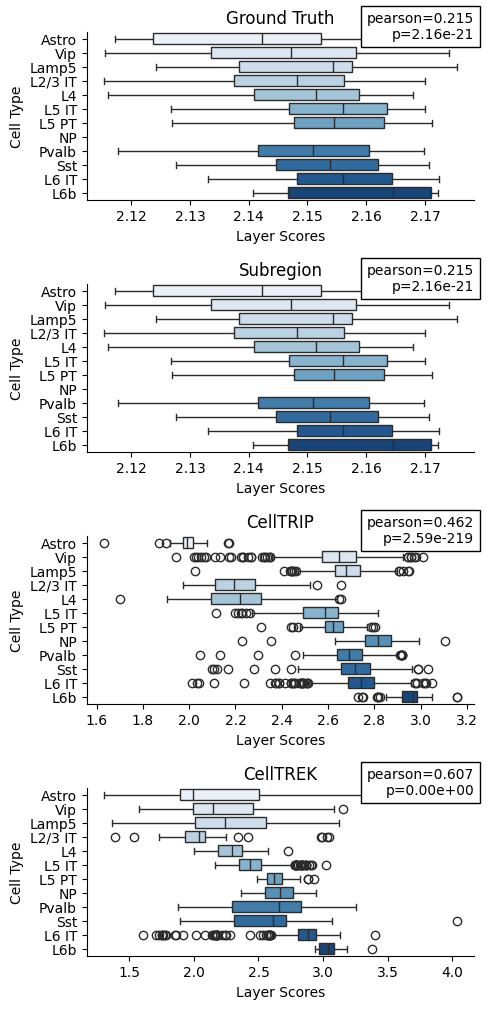

In [9]:
def get_layer_scores(imputed_to_use, cells_to_use=None, cell_types=None):
    # Predict layers
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1_000, weights='distance')
    knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'] .replace({k: v for k, v in zip(cluster_order, range(6))}))
    layer_scores = knn.predict(imputed_to_use)

    # Defaults
    assert cells_to_use is not None or cell_types is not None
    if cells_to_use is None:
        cells_to_use = np.arange(cell_types.shape[0])
    if cell_types is None:
        cell_types = adata_val[cells_to_use].obs['subclass']

    # Format data
    df_impute = pd.DataFrame(index=cells_to_use)
    df_impute['Cell Type'] = cell_types
    ct_nums = {k: v for v, k in enumerate(subclass_order)}
    df_impute['Cell Type Number'] = df_impute['Cell Type'].astype(str).apply(lambda s: ct_nums[s] if s in ct_nums else -1)
    df_impute['Layer Scores'] = layer_scores
    cell_means = df_impute[['Cell Type', 'Layer Scores']].groupby('Cell Type', observed=False).mean()
    df_impute['Mean Diff'] = df_impute['Layer Scores'] - df_impute['Cell Type'].apply(lambda s: cell_means.loc[s, 'Layer Scores']).astype(float)
    df_impute['Mean Diff'] = df_impute['Mean Diff'].abs()
    return df_impute

# Plot
fig, axs = plt.subplots(4, 1, figsize=(5, 12), sharex=False, sharey=True)
fig.subplots_adjust(hspace=.5)
perf_runs = [
    {   'name': 'Ground Truth',
        'cell_types': ground_truth_df['subclass'],
        'imputed_to_use': ground_truth_df[['x', 'y']].to_numpy()},
    {   'name': 'Subregion',
        'cell_types': ground_truth_df['subclass'],
        'imputed_to_use': ground_truth_df[['x', 'y']].to_numpy()},
    {   'name': 'CellTRIP',
        'cells_to_use': adata_val.obs.index[close_mask],
        'imputed_to_use': imputed_steady_state[close_mask]},
    {   'name': 'CellTREK',
        'cells_to_use': celltrek_df.index,
        'imputed_to_use': celltrek_df[['x', 'y']].to_numpy()},
    {   'name': 'Cytospace',
        'cells_to_use': cytospace_df['OriginalCID'],
        'imputed_to_use': cytospace_df[['x', 'y']].to_numpy()}]
for perf_run, ax in zip(perf_runs, axs):
    # Get data
    df_impute = get_layer_scores(
        perf_run['imputed_to_use'],
        cells_to_use=perf_run['cells_to_use'] if 'cells_to_use' in perf_run else None,
        cell_types=perf_run['cell_types'] if 'cell_types' in perf_run else None)

    # Get correlation
    df_impute_filt = df_impute.loc[df_impute['Cell Type Number'] != -1]
    correlation_result = scipy.stats.pearsonr(df_impute_filt['Cell Type Number'], df_impute_filt['Layer Scores'])

    # Plot
    sns.boxplot(
        df_impute.reset_index(),
        x='Layer Scores', y='Cell Type', orient='h', order=subclass_order,
        hue='Cell Type', hue_order=subclass_order, palette='Blues', ax=ax)
    sns.despine(ax=ax)
    ax.set_title(perf_run['name'])
    ax.text(
        1., 1.12, f'pearson={correlation_result.statistic:.3f}\np={correlation_result.pvalue:.2e}',
        ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)

# Perform Perturbation Prediction

In [10]:
# Params
np.random.seed(42)
adatas = [adata_val]
genes_to_survey = adatas[0].var_names
genes_to_survey = np.random.choice(genes_to_survey, 2_000, replace=False)
sim_time = 1.

# Mute warnings (array wrap and indexing)
import warnings
warnings.simplefilter('ignore')

# Create anndata
ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
def add_layers(states, gene):
    ad_pert.layers[gene] = states

# Add results
results = []
def add_record(states, states_0, gene, ct):
    results.append({
        'Gene': gene, 'Cell Type': ct,
        'Effect Size (Latent)': np.square(states[-1] - states[0]).mean(),
        'Trajectory Length (Latent)': np.square(states[1:] - states[:-1]).mean(axis=(-2, -1)).sum(),
        'Effect Size (Spatial)': np.square(states_0[-1] - states_0[0]).mean(),
        'Trajectory Length (Spatial)': np.square(states_0[1:] - states_0[:-1]).mean(axis=(-2, -1)).sum()})
    
# Reset function
def reset_env(env, steady_pos, steady_vel, modal_dict={}):
    env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
    env.set_positions(steady_pos)
    env.set_velocities(steady_vel)  # Maybe 0 manually?
    for k, v in modal_dict.items():
        env.modalities[k] = v

# Running function
def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
    # Run and impute
    states = celltrip.train.simulate_until_completion(
        env, policy,
        env_hooks=[
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            # celltrip.utility.hooks.move_toward_targets_hook(
            #     gene_idx, feature_targets=0., pinning=policy.pinning[0],
            #     preprocessing=preprocessing, modality_idx=0,
            #     factor=1, device=env.device),
        ],
        skip_states=100, store_states='cpu')[-1]
    states_pos = states[..., :env.dim]
    with torch.no_grad():
        imputed_states_1 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
    imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
    # Record
    add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
    add_record(states_pos.numpy(), imputed_states_1, gene, 'All')
    for ct in adatas[0][samples].obs['subclass'].unique():
        add_record(
            states_pos[:, adatas[0][samples].obs['subclass']==ct].numpy(),
            imputed_states_1[:, adatas[0][samples].obs['subclass']==ct],
            gene, ct)

# Subset and preprocess the data
samples = adatas[0].obs.index
# m1, = preprocessing.transform(val_exp, subset_modality=0)
m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)

# Initialize environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')

# Simulate to steady state
env.reset()
celltrip.train.simulate_until_completion(env, policy)
steady_pos, steady_vel = (env.pos, env.vel)

# Run control
reset_env(env, steady_pos, steady_vel)
add_layers(steady_pos.cpu().numpy(), 'Steady')
run_and_record(samples, env, policy, preprocessing, 'Control', [])

# Perturb
for gene in tqdm.tqdm(genes_to_survey, miniters=10, maxinterval=30):
    # Get gene idx and run
    gene_idx = np.argwhere(adatas[0].var_names==gene).flatten()
    reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
    run_and_record(samples, env, policy, preprocessing, gene, gene_idx)

# Convert and save
pd.DataFrame(results).to_csv('../plots/cortex/knockdown.csv', index=None)
ad_pert.write_h5ad('../plots/cortex/knockdown_results.h5ad')



  0%|                                                                                                                                                                                             | 0/2000 [00:00<?, ?it/s]


  0%|▉                                                                                                                                                                                 | 10/2000 [00:18<1:02:12,  1.88s/it]


  1%|█▊                                                                                                                                                                                  | 20/2000 [00:35<58:43,  1.78s/it]


  2%|██▋                                                                                                                                                                               | 30/2000 [00:54<1:00:06,  1.83s/it]


  2%|███▌                                                                                                                                                                                | 40/2000 [01:11<58:21,  1.79s/it]


  2%|████▌                                                                                                                                                                               | 50/2000 [01:30<59:11,  1.82s/it]


  3%|█████▍                                                                                                                                                                              | 60/2000 [01:47<57:20,  1.77s/it]


  4%|██████▎                                                                                                                                                                             | 70/2000 [02:05<57:38,  1.79s/it]


  4%|███████▏                                                                                                                                                                            | 80/2000 [02:23<57:20,  1.79s/it]


  4%|████████                                                                                                                                                                            | 90/2000 [02:42<57:17,  1.80s/it]


  5%|████████▉                                                                                                                                                                          | 100/2000 [02:59<56:14,  1.78s/it]


  6%|█████████▊                                                                                                                                                                         | 110/2000 [03:17<56:53,  1.81s/it]


  6%|██████████▋                                                                                                                                                                        | 120/2000 [03:35<55:48,  1.78s/it]


  6%|███████████▋                                                                                                                                                                       | 130/2000 [03:53<56:19,  1.81s/it]


  7%|████████████▌                                                                                                                                                                      | 140/2000 [04:11<55:10,  1.78s/it]


  8%|█████████████▍                                                                                                                                                                     | 150/2000 [04:29<55:47,  1.81s/it]


  8%|██████████████▎                                                                                                                                                                    | 160/2000 [04:47<55:05,  1.80s/it]


  8%|███████████████▏                                                                                                                                                                   | 170/2000 [05:06<55:25,  1.82s/it]


  9%|████████████████                                                                                                                                                                   | 180/2000 [05:23<54:39,  1.80s/it]


 10%|█████████████████                                                                                                                                                                  | 190/2000 [05:42<54:45,  1.82s/it]


 10%|█████████████████▉                                                                                                                                                                 | 200/2000 [05:59<53:44,  1.79s/it]


 10%|██████████████████▊                                                                                                                                                                | 210/2000 [06:17<53:36,  1.80s/it]


 11%|███████████████████▋                                                                                                                                                               | 220/2000 [06:34<52:39,  1.77s/it]


 12%|████████████████████▌                                                                                                                                                              | 230/2000 [06:53<53:14,  1.80s/it]


 12%|█████████████████████▍                                                                                                                                                             | 240/2000 [07:10<52:08,  1.78s/it]


 12%|██████████████████████▍                                                                                                                                                            | 250/2000 [07:26<50:11,  1.72s/it]


 13%|███████████████████████▎                                                                                                                                                           | 260/2000 [07:42<48:44,  1.68s/it]


 14%|████████████████████████▏                                                                                                                                                          | 270/2000 [07:58<47:33,  1.65s/it]


 14%|█████████████████████████                                                                                                                                                          | 280/2000 [08:14<46:44,  1.63s/it]


 14%|█████████████████████████▉                                                                                                                                                         | 290/2000 [08:30<46:11,  1.62s/it]


 15%|██████████████████████████▊                                                                                                                                                        | 300/2000 [08:46<45:40,  1.61s/it]


 16%|███████████████████████████▋                                                                                                                                                       | 310/2000 [09:01<45:09,  1.60s/it]


 16%|████████████████████████████▋                                                                                                                                                      | 320/2000 [09:18<45:04,  1.61s/it]


 16%|█████████████████████████████▌                                                                                                                                                     | 330/2000 [09:34<44:56,  1.61s/it]


 17%|██████████████████████████████▍                                                                                                                                                    | 340/2000 [09:50<44:19,  1.60s/it]


 18%|███████████████████████████████▎                                                                                                                                                   | 350/2000 [10:06<44:04,  1.60s/it]


 18%|████████████████████████████████▏                                                                                                                                                  | 360/2000 [10:22<43:35,  1.59s/it]


 18%|█████████████████████████████████                                                                                                                                                  | 370/2000 [10:37<43:11,  1.59s/it]


 19%|██████████████████████████████████                                                                                                                                                 | 380/2000 [10:53<42:51,  1.59s/it]


 20%|██████████████████████████████████▉                                                                                                                                                | 390/2000 [11:09<42:28,  1.58s/it]


 20%|███████████████████████████████████▊                                                                                                                                               | 400/2000 [11:25<42:13,  1.58s/it]


 20%|████████████████████████████████████▋                                                                                                                                              | 410/2000 [11:41<42:01,  1.59s/it]


 21%|█████████████████████████████████████▌                                                                                                                                             | 420/2000 [11:56<41:44,  1.59s/it]


 22%|██████████████████████████████████████▍                                                                                                                                            | 430/2000 [12:12<41:29,  1.59s/it]


 22%|███████████████████████████████████████▍                                                                                                                                           | 440/2000 [12:28<41:09,  1.58s/it]


 22%|████████████████████████████████████████▎                                                                                                                                          | 450/2000 [12:44<40:54,  1.58s/it]


 23%|█████████████████████████████████████████▏                                                                                                                                         | 460/2000 [13:00<40:33,  1.58s/it]


 24%|██████████████████████████████████████████                                                                                                                                         | 470/2000 [13:16<40:24,  1.58s/it]


 24%|██████████████████████████████████████████▉                                                                                                                                        | 480/2000 [13:31<40:06,  1.58s/it]


 24%|███████████████████████████████████████████▊                                                                                                                                       | 490/2000 [13:47<39:52,  1.58s/it]


 25%|████████████████████████████████████████████▊                                                                                                                                      | 500/2000 [14:03<39:34,  1.58s/it]


 26%|█████████████████████████████████████████████▋                                                                                                                                     | 510/2000 [14:19<39:14,  1.58s/it]


 26%|██████████████████████████████████████████████▌                                                                                                                                    | 520/2000 [14:35<38:55,  1.58s/it]


 26%|███████████████████████████████████████████████▍                                                                                                                                   | 530/2000 [14:50<38:46,  1.58s/it]


 27%|████████████████████████████████████████████████▎                                                                                                                                  | 540/2000 [15:06<38:33,  1.58s/it]


 28%|█████████████████████████████████████████████████▏                                                                                                                                 | 550/2000 [15:22<38:15,  1.58s/it]


 28%|██████████████████████████████████████████████████                                                                                                                                 | 560/2000 [15:38<37:57,  1.58s/it]


 28%|███████████████████████████████████████████████████                                                                                                                                | 570/2000 [15:54<37:39,  1.58s/it]


 29%|███████████████████████████████████████████████████▉                                                                                                                               | 580/2000 [16:10<37:23,  1.58s/it]


 30%|████████████████████████████████████████████████████▊                                                                                                                              | 590/2000 [16:26<37:19,  1.59s/it]


 30%|█████████████████████████████████████████████████████▋                                                                                                                             | 600/2000 [16:42<37:32,  1.61s/it]


 30%|██████████████████████████████████████████████████████▌                                                                                                                            | 610/2000 [16:58<37:16,  1.61s/it]


 31%|███████████████████████████████████████████████████████▍                                                                                                                           | 620/2000 [17:16<37:51,  1.65s/it]


 32%|████████████████████████████████████████████████████████▍                                                                                                                          | 630/2000 [17:32<37:23,  1.64s/it]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 640/2000 [17:48<36:51,  1.63s/it]


 32%|██████████████████████████████████████████████████████████▏                                                                                                                        | 650/2000 [18:04<36:30,  1.62s/it]


 33%|███████████████████████████████████████████████████████████                                                                                                                        | 660/2000 [18:20<35:56,  1.61s/it]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                       | 670/2000 [18:36<35:38,  1.61s/it]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                      | 680/2000 [18:51<35:10,  1.60s/it]


 34%|█████████████████████████████████████████████████████████████▊                                                                                                                     | 690/2000 [19:07<34:47,  1.59s/it]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 700/2000 [19:23<34:26,  1.59s/it]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                   | 710/2000 [19:39<34:16,  1.59s/it]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 720/2000 [19:55<33:54,  1.59s/it]


 36%|█████████████████████████████████████████████████████████████████▎                                                                                                                 | 730/2000 [20:11<33:37,  1.59s/it]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                | 740/2000 [20:27<33:23,  1.59s/it]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 750/2000 [20:42<33:01,  1.58s/it]


 38%|████████████████████████████████████████████████████████████████████                                                                                                               | 760/2000 [20:58<32:47,  1.59s/it]


 38%|████████████████████████████████████████████████████████████████████▉                                                                                                              | 770/2000 [21:14<32:37,  1.59s/it]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                             | 780/2000 [21:30<32:18,  1.59s/it]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                            | 790/2000 [21:46<32:01,  1.59s/it]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 800/2000 [22:02<31:41,  1.58s/it]


 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                          | 810/2000 [22:18<31:23,  1.58s/it]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                         | 820/2000 [22:33<31:05,  1.58s/it]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                        | 830/2000 [22:49<30:57,  1.59s/it]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                       | 840/2000 [23:05<30:42,  1.59s/it]


 42%|████████████████████████████████████████████████████████████████████████████                                                                                                       | 850/2000 [23:21<30:23,  1.59s/it]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 860/2000 [23:37<30:06,  1.58s/it]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 870/2000 [23:53<29:46,  1.58s/it]


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 880/2000 [24:09<29:31,  1.58s/it]


 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 890/2000 [24:24<29:12,  1.58s/it]


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 900/2000 [24:40<29:06,  1.59s/it]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 910/2000 [24:56<28:50,  1.59s/it]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 920/2000 [25:12<28:36,  1.59s/it]


 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 930/2000 [25:28<28:19,  1.59s/it]


 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 940/2000 [25:44<28:01,  1.59s/it]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                              | 950/2000 [26:00<27:50,  1.59s/it]


 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 960/2000 [26:16<27:36,  1.59s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 970/2000 [26:32<27:19,  1.59s/it]


 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 980/2000 [26:47<26:59,  1.59s/it]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 990/2000 [27:03<26:41,  1.59s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1000/2000 [27:19<26:25,  1.59s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1010/2000 [27:35<26:16,  1.59s/it]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1020/2000 [27:51<26:00,  1.59s/it]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1030/2000 [28:07<25:43,  1.59s/it]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1040/2000 [28:23<25:23,  1.59s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1050/2000 [28:39<25:04,  1.58s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1060/2000 [28:54<24:45,  1.58s/it]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1070/2000 [29:10<24:35,  1.59s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1080/2000 [29:26<24:20,  1.59s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1090/2000 [29:42<24:03,  1.59s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1100/2000 [29:58<23:46,  1.59s/it]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1110/2000 [30:14<23:29,  1.58s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1120/2000 [30:29<23:10,  1.58s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1130/2000 [30:45<23:01,  1.59s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1140/2000 [31:01<22:44,  1.59s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1150/2000 [31:17<22:31,  1.59s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1160/2000 [31:33<22:16,  1.59s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1170/2000 [31:49<21:58,  1.59s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1180/2000 [32:05<21:42,  1.59s/it]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1190/2000 [32:22<21:47,  1.61s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1200/2000 [32:38<21:36,  1.62s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1210/2000 [32:54<21:15,  1.62s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1220/2000 [33:10<20:52,  1.61s/it]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1230/2000 [33:26<20:30,  1.60s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1240/2000 [33:41<20:09,  1.59s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1250/2000 [33:57<19:55,  1.59s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1260/2000 [34:13<19:40,  1.60s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1270/2000 [34:29<19:25,  1.60s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1280/2000 [34:45<19:05,  1.59s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1290/2000 [35:01<18:50,  1.59s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1300/2000 [35:17<18:33,  1.59s/it]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1310/2000 [35:33<18:20,  1.59s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1320/2000 [35:49<18:03,  1.59s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1330/2000 [36:05<17:49,  1.60s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1340/2000 [36:21<17:31,  1.59s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1350/2000 [36:37<17:13,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1360/2000 [36:52<16:54,  1.59s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1370/2000 [37:08<16:42,  1.59s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1380/2000 [37:24<16:27,  1.59s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1390/2000 [37:40<16:12,  1.59s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1400/2000 [37:56<15:56,  1.59s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1410/2000 [38:12<15:38,  1.59s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1420/2000 [38:28<15:21,  1.59s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1430/2000 [38:44<15:08,  1.59s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1440/2000 [39:00<14:53,  1.60s/it]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1450/2000 [39:16<14:35,  1.59s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1460/2000 [39:32<14:18,  1.59s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1470/2000 [39:48<14:12,  1.61s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1480/2000 [40:05<14:04,  1.62s/it]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1490/2000 [40:23<14:13,  1.67s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1500/2000 [40:40<14:04,  1.69s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1510/2000 [40:57<13:48,  1.69s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1520/2000 [41:14<13:38,  1.70s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1530/2000 [41:31<13:21,  1.71s/it]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1540/2000 [41:49<13:06,  1.71s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1550/2000 [42:06<12:54,  1.72s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1560/2000 [42:25<12:55,  1.76s/it]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1570/2000 [42:43<12:43,  1.78s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1580/2000 [43:01<12:29,  1.79s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1590/2000 [43:20<12:25,  1.82s/it]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1600/2000 [43:39<12:16,  1.84s/it]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1610/2000 [43:57<12:00,  1.85s/it]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1620/2000 [44:15<11:33,  1.83s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1630/2000 [44:34<11:20,  1.84s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1640/2000 [44:53<11:11,  1.86s/it]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1650/2000 [45:11<10:50,  1.86s/it]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1660/2000 [45:29<10:23,  1.83s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1670/2000 [45:48<10:04,  1.83s/it]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1680/2000 [46:05<09:41,  1.82s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1690/2000 [46:24<09:27,  1.83s/it]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1700/2000 [46:42<09:06,  1.82s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1710/2000 [47:00<08:50,  1.83s/it]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1720/2000 [47:19<08:34,  1.84s/it]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1730/2000 [47:38<08:17,  1.84s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1740/2000 [47:56<08:00,  1.85s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1750/2000 [48:14<07:39,  1.84s/it]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1760/2000 [48:33<07:22,  1.84s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1770/2000 [48:51<07:04,  1.84s/it]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1780/2000 [49:10<06:48,  1.86s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1790/2000 [49:28<06:28,  1.85s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1800/2000 [49:47<06:11,  1.86s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1810/2000 [50:06<05:52,  1.85s/it]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1820/2000 [50:24<05:34,  1.86s/it]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1830/2000 [50:43<05:15,  1.86s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1840/2000 [51:02<04:57,  1.86s/it]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1850/2000 [51:20<04:37,  1.85s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1860/2000 [51:39<04:19,  1.86s/it]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1870/2000 [51:57<04:01,  1.86s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1880/2000 [52:16<03:42,  1.86s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1890/2000 [52:34<03:22,  1.84s/it]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1900/2000 [52:52<03:03,  1.83s/it]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1910/2000 [53:11<02:46,  1.85s/it]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1920/2000 [53:30<02:29,  1.87s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1930/2000 [53:48<02:10,  1.86s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1940/2000 [54:07<01:50,  1.85s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1950/2000 [54:25<01:31,  1.84s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1960/2000 [54:41<01:10,  1.77s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1970/2000 [54:57<00:51,  1.72s/it]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1980/2000 [55:13<00:33,  1.68s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1990/2000 [55:29<00:16,  1.65s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [55:44<00:00,  1.63s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [55:44<00:00,  1.67s/it]

## Visualize

In [11]:
# Load perturbations
ad_pert = ad.read_h5ad('../plots/cortex/knockdown_results.h5ad')
perturbed_genes = np.setxor1d(list(ad_pert.layers.keys()), ['Control', 'Steady'])

In [12]:
# Compute effect sizes
lat_to_sp = lambda X: preprocessing.inverse_transform(policy.pinning[0](torch.tensor(X, device='cuda')).detach().cpu().numpy(), subset_modality=1)[0]
raw_coords = lat_to_sp(ad_pert.layers['Steady'])
effect_sizes = {}
for gene in tqdm.tqdm(perturbed_genes):
    pert_coords = lat_to_sp(ad_pert.layers[gene])
    effect_sizes[gene] = np.sqrt(np.square(pert_coords - raw_coords).sum(axis=-1))


  0%|                                                                                                                                                                                             | 0/2000 [00:00<?, ?it/s]


  0%|▋                                                                                                                                                                                    | 7/2000 [00:00<00:29, 68.43it/s]


  1%|█▎                                                                                                                                                                                  | 14/2000 [00:00<00:28, 68.60it/s]


  1%|█▉                                                                                                                                                                                  | 21/2000 [00:00<00:28, 68.83it/s]


  1%|██▌                                                                                                                                                                                 | 28/2000 [00:00<00:28, 68.92it/s]


  2%|███▏                                                                                                                                                                                | 35/2000 [00:00<00:28, 69.05it/s]


  2%|███▊                                                                                                                                                                                | 42/2000 [00:00<00:28, 69.04it/s]


  2%|████▍                                                                                                                                                                               | 49/2000 [00:00<00:28, 69.15it/s]


  3%|█████                                                                                                                                                                               | 56/2000 [00:00<00:28, 69.14it/s]


  3%|█████▋                                                                                                                                                                              | 63/2000 [00:00<00:28, 69.09it/s]


  4%|██████▎                                                                                                                                                                             | 70/2000 [00:01<00:27, 69.02it/s]


  4%|██████▉                                                                                                                                                                             | 77/2000 [00:01<00:27, 69.01it/s]


  4%|███████▌                                                                                                                                                                            | 84/2000 [00:01<00:27, 68.91it/s]


  5%|████████▏                                                                                                                                                                           | 91/2000 [00:01<00:27, 68.87it/s]


  5%|████████▊                                                                                                                                                                           | 98/2000 [00:01<00:27, 68.85it/s]


  5%|█████████▍                                                                                                                                                                         | 105/2000 [00:01<00:27, 68.87it/s]


  6%|██████████                                                                                                                                                                         | 112/2000 [00:01<00:27, 68.88it/s]


  6%|██████████▋                                                                                                                                                                        | 119/2000 [00:01<00:27, 68.79it/s]


  6%|███████████▎                                                                                                                                                                       | 126/2000 [00:01<00:27, 68.84it/s]


  7%|███████████▉                                                                                                                                                                       | 133/2000 [00:01<00:27, 68.91it/s]


  7%|████████████▌                                                                                                                                                                      | 140/2000 [00:02<00:26, 68.92it/s]


  7%|█████████████▏                                                                                                                                                                     | 147/2000 [00:02<00:26, 68.92it/s]


  8%|█████████████▊                                                                                                                                                                     | 154/2000 [00:02<00:26, 68.90it/s]


  8%|██████████████▍                                                                                                                                                                    | 161/2000 [00:02<00:26, 68.84it/s]


  8%|███████████████                                                                                                                                                                    | 168/2000 [00:02<00:26, 68.90it/s]


  9%|███████████████▋                                                                                                                                                                   | 175/2000 [00:02<00:26, 68.83it/s]


  9%|████████████████▎                                                                                                                                                                  | 182/2000 [00:02<00:26, 68.98it/s]


  9%|████████████████▉                                                                                                                                                                  | 189/2000 [00:02<00:26, 68.92it/s]


 10%|█████████████████▌                                                                                                                                                                 | 196/2000 [00:02<00:26, 68.87it/s]


 10%|██████████████████▏                                                                                                                                                                | 203/2000 [00:02<00:26, 68.96it/s]


 10%|██████████████████▊                                                                                                                                                                | 210/2000 [00:03<00:25, 68.88it/s]


 11%|███████████████████▍                                                                                                                                                               | 217/2000 [00:03<00:25, 68.78it/s]


 11%|████████████████████                                                                                                                                                               | 224/2000 [00:03<00:25, 68.74it/s]


 12%|████████████████████▋                                                                                                                                                              | 231/2000 [00:03<00:25, 68.77it/s]


 12%|█████████████████████▎                                                                                                                                                             | 238/2000 [00:03<00:25, 68.77it/s]


 12%|█████████████████████▉                                                                                                                                                             | 245/2000 [00:03<00:25, 68.75it/s]


 13%|██████████████████████▌                                                                                                                                                            | 252/2000 [00:03<00:25, 68.89it/s]


 13%|███████████████████████▏                                                                                                                                                           | 259/2000 [00:03<00:25, 68.77it/s]


 13%|███████████████████████▊                                                                                                                                                           | 266/2000 [00:03<00:25, 68.88it/s]


 14%|████████████████████████▍                                                                                                                                                          | 273/2000 [00:03<00:25, 68.90it/s]


 14%|█████████████████████████                                                                                                                                                          | 280/2000 [00:04<00:24, 68.88it/s]


 14%|█████████████████████████▋                                                                                                                                                         | 287/2000 [00:04<00:24, 68.80it/s]


 15%|██████████████████████████▎                                                                                                                                                        | 294/2000 [00:04<00:24, 68.78it/s]


 15%|██████████████████████████▉                                                                                                                                                        | 301/2000 [00:04<00:24, 68.71it/s]


 15%|███████████████████████████▌                                                                                                                                                       | 308/2000 [00:04<00:24, 68.78it/s]


 16%|████████████████████████████▏                                                                                                                                                      | 315/2000 [00:04<00:24, 68.80it/s]


 16%|████████████████████████████▊                                                                                                                                                      | 322/2000 [00:04<00:24, 68.71it/s]


 16%|█████████████████████████████▍                                                                                                                                                     | 329/2000 [00:04<00:24, 68.72it/s]


 17%|██████████████████████████████                                                                                                                                                     | 336/2000 [00:04<00:24, 68.77it/s]


 17%|██████████████████████████████▋                                                                                                                                                    | 343/2000 [00:04<00:24, 68.73it/s]


 18%|███████████████████████████████▎                                                                                                                                                   | 350/2000 [00:05<00:23, 68.76it/s]


 18%|███████████████████████████████▉                                                                                                                                                   | 357/2000 [00:05<00:23, 68.74it/s]


 18%|████████████████████████████████▌                                                                                                                                                  | 364/2000 [00:05<00:23, 68.78it/s]


 19%|█████████████████████████████████▏                                                                                                                                                 | 371/2000 [00:05<00:23, 68.80it/s]


 19%|█████████████████████████████████▊                                                                                                                                                 | 378/2000 [00:05<00:23, 68.78it/s]


 19%|██████████████████████████████████▍                                                                                                                                                | 385/2000 [00:05<00:23, 68.75it/s]


 20%|███████████████████████████████████                                                                                                                                                | 392/2000 [00:05<00:23, 68.86it/s]


 20%|███████████████████████████████████▋                                                                                                                                               | 399/2000 [00:05<00:23, 69.00it/s]


 20%|████████████████████████████████████▎                                                                                                                                              | 406/2000 [00:05<00:23, 68.94it/s]


 21%|████████████████████████████████████▉                                                                                                                                              | 413/2000 [00:05<00:23, 68.91it/s]


 21%|█████████████████████████████████████▌                                                                                                                                             | 420/2000 [00:06<00:23, 68.66it/s]


 21%|██████████████████████████████████████▏                                                                                                                                            | 427/2000 [00:06<00:22, 68.69it/s]


 22%|██████████████████████████████████████▊                                                                                                                                            | 434/2000 [00:06<00:22, 68.74it/s]


 22%|███████████████████████████████████████▍                                                                                                                                           | 441/2000 [00:06<00:22, 68.71it/s]


 22%|████████████████████████████████████████                                                                                                                                           | 448/2000 [00:06<00:22, 68.86it/s]


 23%|████████████████████████████████████████▋                                                                                                                                          | 455/2000 [00:06<00:22, 68.80it/s]


 23%|█████████████████████████████████████████▎                                                                                                                                         | 462/2000 [00:06<00:22, 68.82it/s]


 23%|█████████████████████████████████████████▉                                                                                                                                         | 469/2000 [00:06<00:22, 68.83it/s]


 24%|██████████████████████████████████████████▌                                                                                                                                        | 476/2000 [00:06<00:22, 68.76it/s]


 24%|███████████████████████████████████████████▏                                                                                                                                       | 483/2000 [00:07<00:22, 68.70it/s]


 24%|███████████████████████████████████████████▊                                                                                                                                       | 490/2000 [00:07<00:22, 68.61it/s]


 25%|████████████████████████████████████████████▍                                                                                                                                      | 497/2000 [00:07<00:21, 68.68it/s]


 25%|█████████████████████████████████████████████                                                                                                                                      | 504/2000 [00:07<00:21, 68.73it/s]


 26%|█████████████████████████████████████████████▋                                                                                                                                     | 511/2000 [00:07<00:21, 68.81it/s]


 26%|██████████████████████████████████████████████▎                                                                                                                                    | 518/2000 [00:07<00:21, 68.73it/s]


 26%|██████████████████████████████████████████████▉                                                                                                                                    | 525/2000 [00:07<00:21, 68.83it/s]


 27%|███████████████████████████████████████████████▌                                                                                                                                   | 532/2000 [00:07<00:21, 68.79it/s]


 27%|████████████████████████████████████████████████▏                                                                                                                                  | 539/2000 [00:07<00:21, 68.82it/s]


 27%|████████████████████████████████████████████████▊                                                                                                                                  | 546/2000 [00:07<00:21, 68.81it/s]


 28%|█████████████████████████████████████████████████▍                                                                                                                                 | 553/2000 [00:08<00:21, 68.71it/s]


 28%|██████████████████████████████████████████████████                                                                                                                                 | 560/2000 [00:08<00:20, 68.72it/s]


 28%|██████████████████████████████████████████████████▋                                                                                                                                | 567/2000 [00:08<00:20, 68.69it/s]


 29%|███████████████████████████████████████████████████▎                                                                                                                               | 574/2000 [00:08<00:20, 68.70it/s]


 29%|███████████████████████████████████████████████████▉                                                                                                                               | 581/2000 [00:08<00:20, 68.76it/s]


 29%|████████████████████████████████████████████████████▋                                                                                                                              | 588/2000 [00:08<00:20, 68.76it/s]


 30%|█████████████████████████████████████████████████████▎                                                                                                                             | 595/2000 [00:08<00:20, 68.76it/s]


 30%|█████████████████████████████████████████████████████▉                                                                                                                             | 602/2000 [00:08<00:20, 68.75it/s]


 30%|██████████████████████████████████████████████████████▌                                                                                                                            | 609/2000 [00:08<00:20, 68.79it/s]


 31%|███████████████████████████████████████████████████████▏                                                                                                                           | 616/2000 [00:08<00:20, 68.75it/s]


 31%|███████████████████████████████████████████████████████▊                                                                                                                           | 623/2000 [00:09<00:20, 68.78it/s]


 32%|████████████████████████████████████████████████████████▍                                                                                                                          | 630/2000 [00:09<00:19, 68.71it/s]


 32%|█████████████████████████████████████████████████████████                                                                                                                          | 637/2000 [00:09<00:19, 68.63it/s]


 32%|█████████████████████████████████████████████████████████▋                                                                                                                         | 644/2000 [00:09<00:19, 68.70it/s]


 33%|██████████████████████████████████████████████████████████▎                                                                                                                        | 651/2000 [00:09<00:19, 68.67it/s]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                        | 658/2000 [00:09<00:19, 68.74it/s]


 33%|███████████████████████████████████████████████████████████▌                                                                                                                       | 665/2000 [00:09<00:19, 68.81it/s]


 34%|████████████████████████████████████████████████████████████▏                                                                                                                      | 672/2000 [00:09<00:19, 68.80it/s]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                      | 679/2000 [00:09<00:19, 68.70it/s]


 34%|█████████████████████████████████████████████████████████████▍                                                                                                                     | 686/2000 [00:09<00:19, 68.87it/s]


 35%|██████████████████████████████████████████████████████████████                                                                                                                     | 693/2000 [00:10<00:18, 68.87it/s]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 700/2000 [00:10<00:18, 68.84it/s]


 35%|███████████████████████████████████████████████████████████████▎                                                                                                                   | 707/2000 [00:10<00:18, 68.91it/s]


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                   | 714/2000 [00:10<00:18, 68.94it/s]


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                  | 721/2000 [00:10<00:18, 68.89it/s]


 36%|█████████████████████████████████████████████████████████████████▏                                                                                                                 | 728/2000 [00:10<00:18, 69.01it/s]


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                 | 735/2000 [00:10<00:18, 69.00it/s]


 37%|██████████████████████████████████████████████████████████████████▍                                                                                                                | 742/2000 [00:10<00:18, 69.04it/s]


 37%|███████████████████████████████████████████████████████████████████                                                                                                                | 749/2000 [00:10<00:18, 69.01it/s]


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                               | 756/2000 [00:10<00:18, 69.00it/s]


 38%|████████████████████████████████████████████████████████████████████▎                                                                                                              | 763/2000 [00:11<00:17, 69.04it/s]


 38%|████████████████████████████████████████████████████████████████████▉                                                                                                              | 770/2000 [00:11<00:17, 68.92it/s]


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                             | 777/2000 [00:11<00:17, 69.02it/s]


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                            | 784/2000 [00:11<00:17, 68.96it/s]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                            | 791/2000 [00:11<00:17, 68.99it/s]


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                           | 798/2000 [00:11<00:17, 68.96it/s]


 40%|████████████████████████████████████████████████████████████████████████                                                                                                           | 805/2000 [00:11<00:17, 68.79it/s]


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                          | 812/2000 [00:11<00:17, 68.85it/s]


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                         | 819/2000 [00:11<00:17, 68.79it/s]


 41%|█████████████████████████████████████████████████████████████████████████▉                                                                                                         | 826/2000 [00:12<00:17, 68.70it/s]


 42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                        | 833/2000 [00:12<00:16, 68.67it/s]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                       | 840/2000 [00:12<00:16, 68.64it/s]


 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                       | 847/2000 [00:12<00:16, 68.71it/s]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 854/2000 [00:12<00:16, 68.80it/s]


 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                      | 861/2000 [00:12<00:16, 68.71it/s]


 43%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 868/2000 [00:12<00:16, 68.79it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 875/2000 [00:12<00:16, 68.87it/s]


 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 882/2000 [00:12<00:16, 68.93it/s]


 44%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 889/2000 [00:12<00:16, 68.67it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 896/2000 [00:13<00:16, 68.67it/s]


 45%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 903/2000 [00:13<00:15, 68.72it/s]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 910/2000 [00:13<00:15, 68.63it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                                 | 917/2000 [00:13<00:15, 68.60it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 924/2000 [00:13<00:15, 68.64it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 931/2000 [00:13<00:15, 68.79it/s]


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 938/2000 [00:13<00:15, 68.78it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 945/2000 [00:13<00:15, 68.78it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 952/2000 [00:13<00:15, 68.80it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 959/2000 [00:13<00:15, 68.96it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 966/2000 [00:14<00:14, 69.01it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                            | 973/2000 [00:14<00:14, 69.07it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 980/2000 [00:14<00:14, 69.10it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 987/2000 [00:14<00:14, 68.98it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 994/2000 [00:14<00:14, 69.04it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1001/2000 [00:14<00:14, 68.95it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1008/2000 [00:14<00:14, 68.99it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1015/2000 [00:14<00:14, 68.98it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1022/2000 [00:14<00:14, 68.87it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1029/2000 [00:14<00:14, 68.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1036/2000 [00:15<00:13, 68.88it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1043/2000 [00:15<00:13, 68.85it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1050/2000 [00:15<00:13, 68.75it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1057/2000 [00:15<00:13, 68.70it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1064/2000 [00:15<00:13, 68.72it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1071/2000 [00:15<00:13, 68.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1078/2000 [00:15<00:13, 68.74it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1085/2000 [00:15<00:13, 68.77it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1092/2000 [00:15<00:13, 68.82it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1099/2000 [00:15<00:13, 68.77it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1106/2000 [00:16<00:13, 68.77it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1113/2000 [00:16<00:12, 68.78it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1120/2000 [00:16<00:12, 68.51it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1127/2000 [00:16<00:12, 68.42it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1134/2000 [00:16<00:12, 68.55it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1141/2000 [00:16<00:12, 68.57it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1148/2000 [00:16<00:12, 68.65it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1155/2000 [00:16<00:12, 68.72it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1162/2000 [00:16<00:12, 68.74it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1169/2000 [00:16<00:12, 68.77it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1176/2000 [00:17<00:11, 68.70it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1183/2000 [00:17<00:11, 68.74it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1190/2000 [00:17<00:11, 68.78it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1197/2000 [00:17<00:11, 68.91it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1204/2000 [00:17<00:11, 68.94it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1211/2000 [00:17<00:11, 68.92it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1218/2000 [00:17<00:11, 68.83it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1225/2000 [00:17<00:11, 68.74it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1232/2000 [00:17<00:11, 68.80it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1239/2000 [00:18<00:11, 68.81it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1246/2000 [00:18<00:10, 68.79it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1253/2000 [00:18<00:10, 68.78it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1260/2000 [00:18<00:10, 68.74it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1267/2000 [00:18<00:10, 68.68it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1274/2000 [00:18<00:10, 68.71it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1281/2000 [00:18<00:10, 68.71it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1288/2000 [00:18<00:10, 68.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1295/2000 [00:18<00:10, 68.77it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1302/2000 [00:18<00:10, 68.72it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1309/2000 [00:19<00:10, 68.81it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1316/2000 [00:19<00:09, 68.84it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1323/2000 [00:19<00:09, 68.83it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1330/2000 [00:19<00:09, 68.81it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1337/2000 [00:19<00:09, 68.74it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1344/2000 [00:19<00:09, 68.72it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1351/2000 [00:19<00:09, 68.83it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1358/2000 [00:19<00:09, 68.75it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1365/2000 [00:19<00:09, 68.85it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1372/2000 [00:19<00:09, 68.82it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1379/2000 [00:20<00:09, 68.88it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1386/2000 [00:20<00:08, 68.97it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1393/2000 [00:20<00:08, 68.84it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1400/2000 [00:20<00:08, 68.79it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1407/2000 [00:20<00:08, 68.80it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1414/2000 [00:20<00:08, 68.82it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1421/2000 [00:20<00:08, 68.88it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1428/2000 [00:20<00:08, 68.93it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1435/2000 [00:20<00:08, 68.92it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1442/2000 [00:20<00:08, 68.96it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1449/2000 [00:21<00:07, 68.92it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1456/2000 [00:21<00:07, 68.74it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1463/2000 [00:21<00:07, 68.66it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1470/2000 [00:21<00:07, 68.65it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1477/2000 [00:21<00:07, 68.75it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1484/2000 [00:21<00:07, 68.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1491/2000 [00:21<00:07, 68.84it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1498/2000 [00:21<00:07, 68.83it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1505/2000 [00:21<00:07, 68.84it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1512/2000 [00:21<00:07, 68.89it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1519/2000 [00:22<00:06, 68.90it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1526/2000 [00:22<00:06, 68.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1533/2000 [00:22<00:06, 68.68it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1540/2000 [00:22<00:06, 68.74it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1547/2000 [00:22<00:06, 68.76it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1554/2000 [00:22<00:06, 68.72it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1561/2000 [00:22<00:06, 68.82it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1568/2000 [00:22<00:06, 68.70it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1575/2000 [00:22<00:06, 68.80it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1582/2000 [00:22<00:06, 68.77it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1589/2000 [00:23<00:05, 68.81it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1596/2000 [00:23<00:05, 68.76it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1603/2000 [00:23<00:05, 68.79it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1610/2000 [00:23<00:05, 68.73it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1617/2000 [00:23<00:05, 68.73it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1624/2000 [00:23<00:05, 68.72it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1631/2000 [00:23<00:05, 68.82it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1638/2000 [00:23<00:05, 68.78it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1645/2000 [00:23<00:05, 68.80it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1652/2000 [00:24<00:05, 68.71it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1659/2000 [00:24<00:04, 68.77it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1666/2000 [00:24<00:04, 68.64it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1673/2000 [00:24<00:04, 68.68it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1680/2000 [00:24<00:04, 68.76it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1687/2000 [00:24<00:04, 68.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1694/2000 [00:24<00:04, 68.76it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1701/2000 [00:24<00:04, 68.65it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1708/2000 [00:24<00:04, 68.66it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1715/2000 [00:24<00:04, 68.69it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1722/2000 [00:25<00:04, 68.56it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1729/2000 [00:25<00:03, 68.59it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1736/2000 [00:25<00:03, 68.50it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1743/2000 [00:25<00:03, 68.59it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1750/2000 [00:25<00:03, 68.64it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1757/2000 [00:25<00:03, 68.71it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1764/2000 [00:25<00:03, 68.69it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1771/2000 [00:25<00:03, 68.60it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1778/2000 [00:25<00:03, 68.60it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1785/2000 [00:25<00:03, 68.50it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1792/2000 [00:26<00:03, 68.54it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1799/2000 [00:26<00:02, 68.57it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1806/2000 [00:26<00:02, 68.58it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1813/2000 [00:26<00:02, 68.59it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1820/2000 [00:26<00:02, 68.70it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1827/2000 [00:26<00:02, 68.58it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1834/2000 [00:26<00:02, 68.60it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1841/2000 [00:26<00:02, 68.64it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1848/2000 [00:26<00:02, 68.81it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1855/2000 [00:26<00:02, 68.88it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1862/2000 [00:27<00:02, 68.90it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1869/2000 [00:27<00:01, 68.89it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1876/2000 [00:27<00:01, 68.86it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1883/2000 [00:27<00:01, 68.91it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1890/2000 [00:27<00:01, 68.99it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1897/2000 [00:27<00:01, 68.99it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1904/2000 [00:27<00:01, 68.87it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1911/2000 [00:27<00:01, 68.78it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1918/2000 [00:27<00:01, 68.72it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1925/2000 [00:27<00:01, 68.77it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1932/2000 [00:28<00:00, 68.83it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1939/2000 [00:28<00:00, 68.73it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1946/2000 [00:28<00:00, 68.79it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1953/2000 [00:28<00:00, 68.77it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1960/2000 [00:28<00:00, 68.82it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1967/2000 [00:28<00:00, 68.84it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1974/2000 [00:28<00:00, 68.87it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1981/2000 [00:28<00:00, 68.68it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1988/2000 [00:28<00:00, 68.66it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1995/2000 [00:28<00:00, 68.73it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.79it/s]

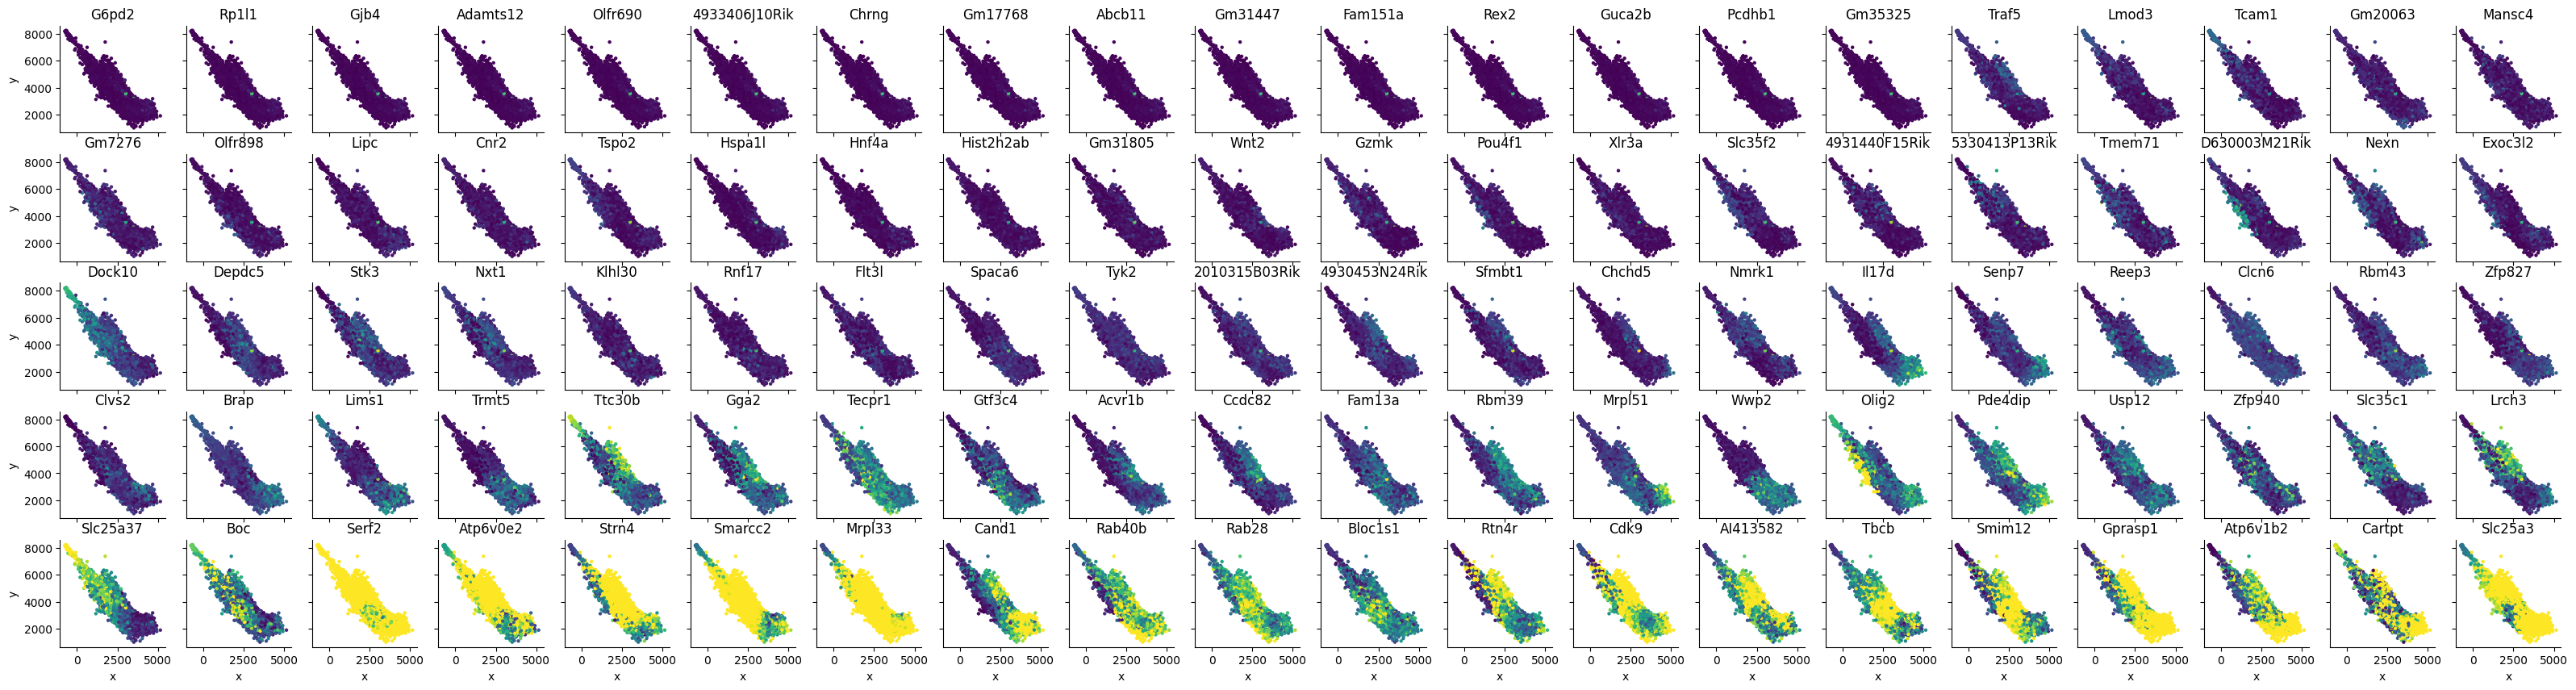

In [13]:
# Choose genes
genes_to_show = perturbed_genes
np.random.seed(42)
genes_to_show = np.random.choice(genes_to_show, 100, replace=False)

# Dendogram Sorting
df = pd.DataFrame(index=genes_to_show, columns=adata_val.obs.index).astype(float)
df[:] = np.stack([effect_sizes[g] for g in genes_to_show], axis=0)
# Sort
dist = scipy.spatial.distance.pdist(df)
linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
genes_to_show = genes_to_show[ordered_leaves]

# Styling
cmap = sns.color_palette('viridis', as_cmap=True)

# Initialize
fig, axs = plt.subplots(5, np.ceil(len(genes_to_show)/5).astype(int), figsize=(40, 10), sharex=True, sharey=True)
axs = axs.flatten()
for ax, gene in zip(axs, genes_to_show):
    df = pd.DataFrame(index=adata_val.obs.index)
    df[['x', 'y']] = raw_coords
    df['Effect Size'] = effect_sizes[gene]
    sns.scatterplot(df, x='x', y='y', s=10, edgecolor='none', hue='Effect Size', hue_norm=(0, 20), palette='viridis', ax=ax, legend=False)
    sns.despine(ax=ax)
    ax.set_title(gene)